# Lactation Curves API Tutorial

This notebook walks you through using the **Lactation Curves API** — a REST API that fits
mathematical models to dairy cow milk production data and calculates lactation characteristics.

## What you'll learn

1. How to run the API on your own computer ("locally")
2. How to send requests to the API and interpret responses
3. How to use the deployed (cloud) version of the API

## What is an API?

An **API** (Application Programming Interface) is a way for programs to talk to each other.
In our case, the Lactation Curves API is a **web API** — a program that listens for HTTP
requests (like the ones your browser makes) and sends back data.

The flow looks like this:

```
Your code (this notebook)  -->  HTTP request  -->  API server  -->  processes data  -->  HTTP response  -->  back to you
```

Our API is built with **FastAPI** (a Python web framework) and served by **Uvicorn** (an ASGI
server — think of it as the engine that actually handles network connections).

## Available endpoints

| Endpoint | Method | Description |
|----------|--------|-------------|
| `/` | GET | Health check — verify the API is running |
| `/fit` | POST | Fit a lactation curve model to milk recording data |
| `/characteristic` | POST | Calculate a lactation characteristic (peak yield, persistency, etc.) |
| `/predict` | POST | Evaluate the MilkBot model with known parameters |
| `/test-interval` | POST | Calculate 305-day yield using the ICAR Test Interval Method |

## Prerequisites

Before running this notebook, make sure you have:

1. **Python 3.12** installed
2. **[uv](https://docs.astral.sh/uv/)** — a fast Python package manager. Install it with:
   ```bash
   curl -LsSf https://astral.sh/uv/install.sh | sh
   ```
3. **Project dependencies** installed. From the project root, run:
   ```bash
   uv sync
   ```
4. **[just](https://github.com/casey/just)** — a command runner (optional but recommended). Install with:
   ```bash
   brew install just              # macOS (Homebrew)
   winget install Casey.Just      # Windows (winget)
   scoop install just             # Windows (Scoop)
   cargo install just             # any OS via Rust
   ```

The notebook uses `httpx` for HTTP requests and `matplotlib` for plotting — both are
already included in the project dependencies.

---

## Part 1: Running the API Locally

### What does "running a server" mean?

When you "run the API locally", you start a program on your computer that:
1. **Listens** on a network port (default: 8000)
2. **Waits** for incoming HTTP requests
3. **Processes** each request (e.g., fits a lactation curve)
4. **Returns** a response with the results

The server keeps running in your terminal until you stop it (Ctrl+C).

### Step 1: Open a terminal

A **terminal** (also called command line, shell, or console) is a text-based interface where
you type commands. You need it to start the API server.

**macOS:**
- Open **Spotlight** (Cmd + Space), type `Terminal`, and press Enter
- Or find it in Applications > Utilities > Terminal

**Windows:**
- Press **Win + R**, type `cmd`, and press Enter (Command Prompt)
- Or press **Win + X** and select **Windows Terminal** / **PowerShell**
- Or search for "Terminal" in the Start menu

**VS Code (any OS):**
- Press **Ctrl + `** (backtick) to open the built-in terminal
- Or go to the menu: Terminal > New Terminal

> **Tip:** If you're using VS Code or another IDE, the built-in terminal is the easiest
> option — it opens right inside your editor.

### Step 2: Navigate to the project

In the terminal, use `cd` (change directory) to go to the project root:
```bash
cd /path/to/lactation_curve_core
```

### Step 3: Start the server

```bash
just run
```
Or equivalently (if you don't have `just`):
```bash
cd apps/lactation_curves && uv run python -m uvicorn main:app --reload
```

In VS code 
```bash
cd apps/lactation_curves
uv run python -m uvicorn main:app --reload
```

You should see output like:
```
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [...]
```

**What does `--reload` do?** It watches for file changes and automatically restarts the
server when you edit the code. Great for development, not used in production.

### Interactive API docs

Once the server is running, open your browser and go to:
- **http://localhost:8000/docs** — Swagger UI where you can try endpoints interactively
- **http://localhost:8000/openapi.json** — the raw API specification

> **Important:** Keep the terminal with the server running while you work through this notebook.
> The API must be running for the code cells below to work.

### Setup: imports and base URL

In [1]:
import httpx
import matplotlib.pyplot as plt

# Point to your local server.
# Change this to the deployed URL later (see Part 6).
BASE_URL = "http://localhost:8000"

### Health check

Let's verify the API is running. The `/` endpoint returns `{"status": "ok"}` if everything is fine.

In [2]:
response = httpx.get(f"{BASE_URL}/")
print(f"Status code: {response.status_code}")
print(f"Response:    {response.json()}")

Status code: 200
Response:    {'status': 'ok'}


If you see `Status code: 200` and `{"status": "ok"}`, the API is running.

If you get a **ConnectionError**, make sure:
- The server is running in another terminal
- It's listening on port 8000 (the default)

---

## Part 2: Fitting a Lactation Curve — `/fit`

The `/fit` endpoint takes **test-day milk recordings** (days in milk + milk yield in kg)
and fits a mathematical model to the data. It returns **predicted daily milk yields**
for DIM 1 through 305.

### Input fields

| Field | Type | Required | Description |
|-------|------|----------|-------------|
| `dim` | list of ints | Yes | Days in milk for each test day |
| `milkrecordings` | list of floats | Yes | Milk yield (kg) for each test day |
| `model` | string | No (default: `"wood"`) | Model: `wood`, `wilmink`, `ali_schaeffer`, `fischer`, `milkbot` |
| `fitting` | string | No (default: `"frequentist"`) | Fitting method (only `frequentist` supported) |
| `breed` | string | No (default: `"H"`) | Breed: `H` (Holstein), `J` (Jersey) |
| `parity` | int | No (default: `3`) | Lactation number (>= 1) |
| `continent` | string | No (default: `"USA"`) | Prior source: `USA`, `EU`, `CHEN` |

### Sample data

We'll use 9 test-day recordings from a typical Holstein cow:

In [3]:
# Sample test-day data: 9 recordings across a 305-day lactation
sample_data = {
    "dim": [10, 30, 60, 90, 120, 150, 200, 250, 305],
    "milkrecordings": [15.0, 25.0, 30.0, 28.0, 26.0, 24.0, 22.0, 20.0, 18.0],
}

### Fit with the Wood model

The **Wood model** is a classic 3-parameter gamma function: `y(t) = a * t^b * exp(-c*t)`.
It captures the typical rise-to-peak-then-decline shape of a lactation curve.

In [4]:
fit_request = {
    **sample_data,
    "model": "wood",
}

response = httpx.post(f"{BASE_URL}/fit", json=fit_request, timeout=30)
print(f"Status code: {response.status_code}")

result = response.json()
predictions = result["predictions"]
print(f"Number of predicted values: {len(predictions)}")
print(f"First 10 predictions (DIM 1-10): {predictions[:10]}")

Status code: 200
Number of predicted values: 305
First 10 predictions (DIM 1-10): [6.77571590978353, 8.971701022592034, 10.551526169243571, 11.821678533309615, 12.897163306501191, 13.835803404657055, 14.671467070407104, 15.425988262455181, 16.11440849082292, 16.74760847007501]


### Plot the fitted curve

Let's visualize the fitted curve alongside the original test-day recordings.

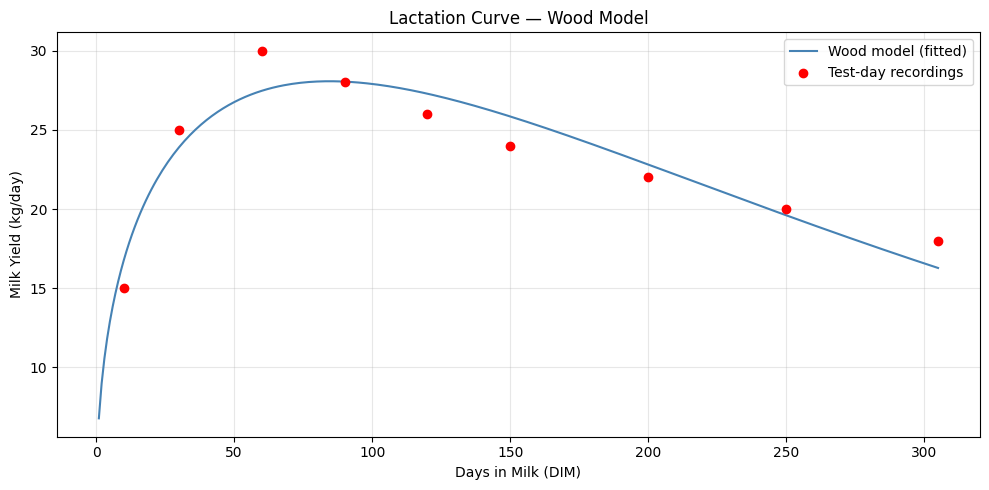

In [5]:
dim_predicted = list(range(1, len(predictions) + 1))

plt.figure(figsize=(10, 5))
plt.plot(dim_predicted, predictions, label="Wood model (fitted)", color="steelblue")
plt.scatter(
    sample_data["dim"],
    sample_data["milkrecordings"],
    color="red",
    zorder=5,
    label="Test-day recordings",
)
plt.xlabel("Days in Milk (DIM)")
plt.ylabel("Milk Yield (kg/day)")
plt.title("Lactation Curve — Wood Model")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Compare multiple models

Let's fit all five available models and compare them visually.

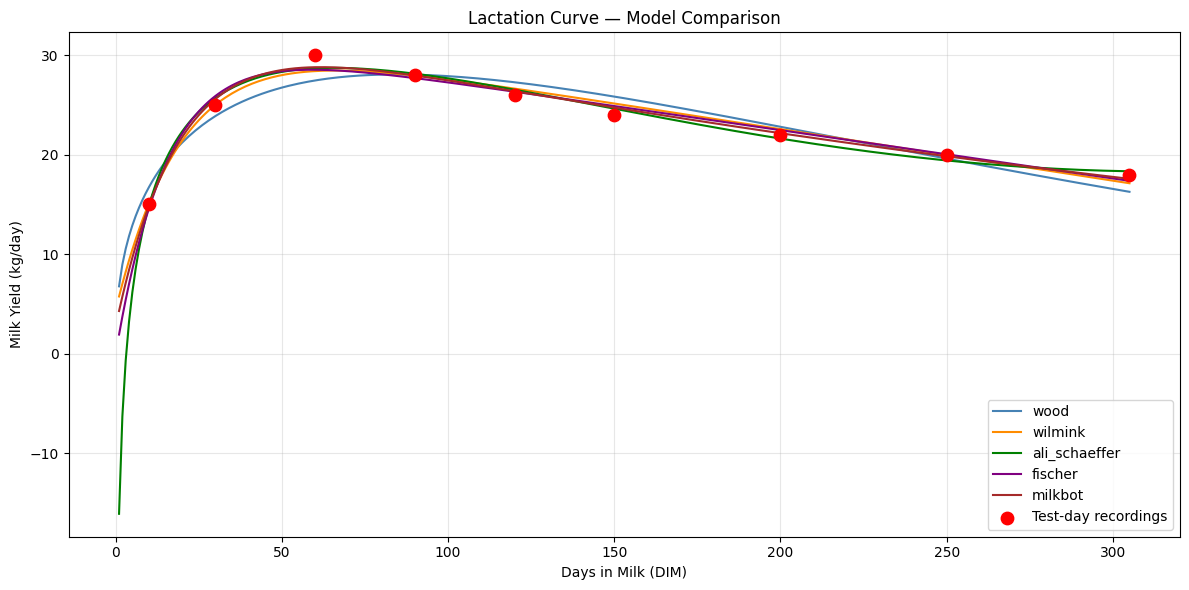

In [6]:
models = ["wood", "wilmink", "ali_schaeffer", "fischer", "milkbot"]
colors = ["steelblue", "darkorange", "green", "purple", "brown"]

plt.figure(figsize=(12, 6))

for model_name, color in zip(models, colors):
    resp = httpx.post(
        f"{BASE_URL}/fit",
        json={**sample_data, "model": model_name},
        timeout=30,
    )
    preds = resp.json()["predictions"]
    plt.plot(range(1, len(preds) + 1), preds, label=model_name, color=color)

plt.scatter(
    sample_data["dim"],
    sample_data["milkrecordings"],
    color="red",
    zorder=5,
    s=80,
    label="Test-day recordings",
)
plt.xlabel("Days in Milk (DIM)")
plt.ylabel("Milk Yield (kg/day)")
plt.title("Lactation Curve — Model Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Part 3: Calculating Lactation Characteristics — `/characteristic`

Instead of getting the full curve, you can ask for a single summary statistic:

| Characteristic | Description |
|----------------|-------------|
| `time_to_peak` | Day in milk at which peak yield occurs |
| `peak_yield` | Maximum daily milk yield (kg) |
| `cumulative_milk_yield` | Total milk produced over the lactation (kg) |
| `persistency` | Rate of decline after peak |

In [7]:
characteristics = ["time_to_peak", "peak_yield", "cumulative_milk_yield", "persistency"]

print("Lactation characteristics (Wood model, Holstein, parity 3):")
print("-" * 55)

for char in characteristics:
    resp = httpx.post(
        f"{BASE_URL}/characteristic",
        json={**sample_data, "model": "wood", "characteristic": char},
        timeout=30,
    )
    value = resp.json()["value"]
    print(f"{char:<30} {value:.2f}")

Lactation characteristics (Wood model, Holstein, parity 3):
-------------------------------------------------------
time_to_peak                   84.60
peak_yield                     28.07
cumulative_milk_yield          7052.90
persistency                    -0.05


---

## Part 4: Direct MilkBot Prediction — `/predict`

If you already **know** the MilkBot model parameters (a, b, c, d), you can get
predictions directly without fitting. This is useful when you have parameters from
a previous analysis or from the literature.

The MilkBot model: `y(t) = a * (1 - exp((c - t) / b) / 2) * exp(-d * t)`

| Parameter | Meaning |
|-----------|--------|
| `a` | Scale — overall production level (kg) |
| `b` | Ramp — rate of rise in early lactation |
| `c` | Offset — time correction for calving |
| `d` | Decay — rate of exponential decline |

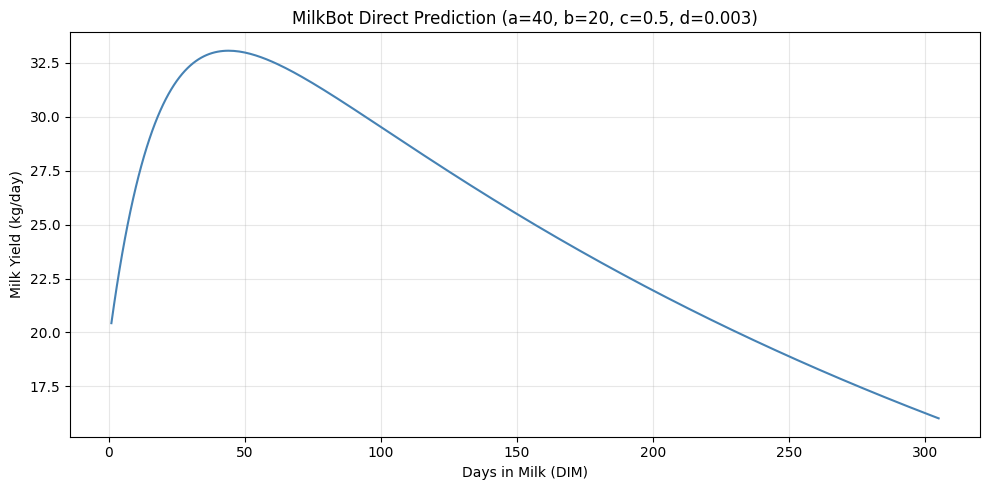

In [8]:
predict_request = {
    "t": list(range(1, 306)),  # DIM 1 through 305
    "a": 40.0,
    "b": 20.0,
    "c": 0.5,
    "d": 0.003,
}

response = httpx.post(f"{BASE_URL}/predict", json=predict_request, timeout=30)
preds = response.json()["predictions"]

plt.figure(figsize=(10, 5))
plt.plot(range(1, 306), preds, color="steelblue")
plt.xlabel("Days in Milk (DIM)")
plt.ylabel("Milk Yield (kg/day)")
plt.title("MilkBot Direct Prediction (a=40, b=20, c=0.5, d=0.003)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Part 5: ICAR Test Interval Method — `/test-interval`

The **ICAR Test Interval Method** calculates the total 305-day milk yield using the
trapezoidal rule — a standard method recognized by the International Committee for
Animal Recording (ICAR). It does **not** fit a mathematical model; instead, it
interpolates between test days.

### Single lactation

In [9]:
response = httpx.post(
    f"{BASE_URL}/test-interval",
    json=sample_data,
    timeout=30,
)
result = response.json()
print("ICAR Test Interval Method result:")
for r in result["results"]:
    print(f"  Test ID: {r['test_id']}  |  305-day yield: {r['total_305_yield']:.1f} kg")

ICAR Test Interval Method result:
  Test ID: 1.0  |  305-day yield: 7068.0 kg


### Multiple lactations

You can process multiple animals/lactations in a single request by providing `test_ids`.

In [10]:
multi_request = {
    "dim": [10, 30, 60, 90, 120, 10, 30, 60, 90, 120],
    "milkrecordings": [15.0, 25.0, 30.0, 28.0, 26.0, 20.0, 30.0, 35.0, 32.0, 28.0],
    "test_ids": ["cow_A", "cow_A", "cow_A", "cow_A", "cow_A",
                 "cow_B", "cow_B", "cow_B", "cow_B", "cow_B"],
}

response = httpx.post(f"{BASE_URL}/test-interval", json=multi_request, timeout=30)
result = response.json()

print("Multiple lactation results:")
for r in result["results"]:
    print(f"  {r['test_id']}  |  305-day yield: {r['total_305_yield']:.1f} kg")

Multiple lactation results:
  cow_A  |  305-day yield: 7891.0 kg
  cow_B  |  305-day yield: 8788.0 kg


---

## Part 6: Using the Deployed API

So far we've been talking to the API running on your own machine. But the same API
is also **deployed to the cloud** (Azure Functions), which means you can use it
without running anything locally.

### Local vs Deployed

| | Local | Deployed |
|---|---|---|
| URL | `http://localhost:8000` | `https://milkbot-dev-func.azurewebsites.net` |
| Requires server running? | Yes (in your terminal) | No (always available) |
| Speed | Fast (no network latency) | Slightly slower (network round-trip) |
| Authentication | None | None (anonymous access) |
| Best for | Development, debugging | Production use, sharing with others |

> **Note:** The deployed API runs on Azure Functions which has a **cold start** time.
> The first request after a period of inactivity may take 10–30 seconds while the
> server spins up. Subsequent requests will be fast.

To switch, just change `BASE_URL`:

In [11]:
DEPLOYED_URL = "https://milkbot-dev-func.azurewebsites.net"

# Health check against the deployed API
# Note: the Azure Function may need 10-30 seconds to start up on the first request
# (cold start), so we use a longer timeout here.
response = httpx.get(f"{DEPLOYED_URL}/", timeout=60)
print(f"Deployed API status: {response.status_code} — {response.json()}")

Deployed API status: 200 — {'status': 'ok'}


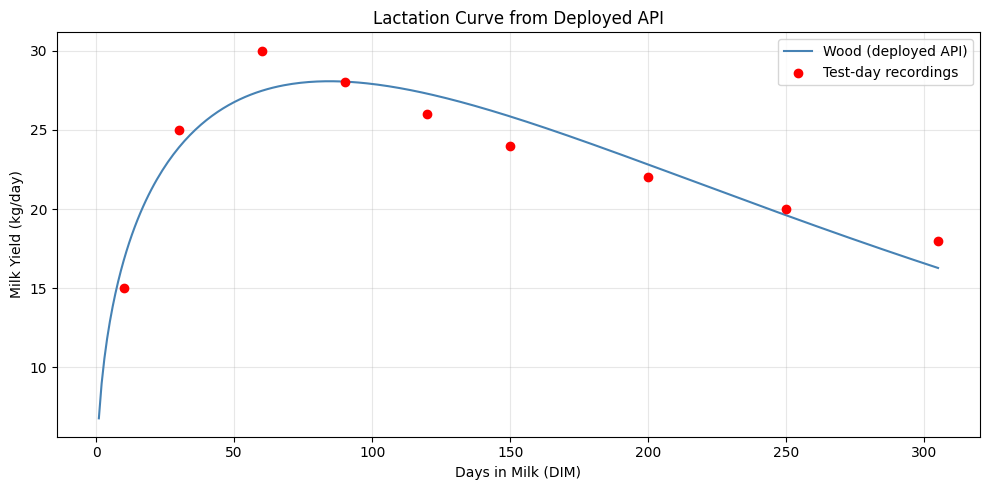

In [12]:
# Fit a curve using the deployed API — same request, different URL
response = httpx.post(
    f"{DEPLOYED_URL}/fit",
    json={**sample_data, "model": "wood"},
    timeout=60,
)
preds = response.json()["predictions"]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(preds) + 1), preds, label="Wood (deployed API)", color="steelblue")
plt.scatter(
    sample_data["dim"],
    sample_data["milkrecordings"],
    color="red",
    zorder=5,
    label="Test-day recordings",
)
plt.xlabel("Days in Milk (DIM)")
plt.ylabel("Milk Yield (kg/day)")
plt.title("Lactation Curve from Deployed API")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Part 7: Error Handling

The API validates your input and returns clear error messages when something is wrong.
Here are some common errors and how to read them.

In [13]:
# Error: dim and milkrecordings have different lengths
bad_request = {
    "dim": [10, 30, 60],
    "milkrecordings": [15.0, 25.0],  # only 2 values instead of 3
    "model": "wood",
}

response = httpx.post(f"{BASE_URL}/fit", json=bad_request, timeout=30)
print(f"Status code: {response.status_code}")
print(f"Error detail: {response.json()['detail']}")

Status code: 422
Error detail: [{'type': 'value_error', 'loc': ['body'], 'msg': 'Value error, dim and milkrecordings must have the same length, got 3 and 2', 'input': {'dim': [10, 30, 60], 'milkrecordings': [15.0, 25.0], 'model': 'wood'}, 'ctx': {'error': {}}}]


In [14]:
# Error: invalid model name
bad_request = {
    **sample_data,
    "model": "invalid_model",
}

response = httpx.post(f"{BASE_URL}/fit", json=bad_request, timeout=30)
print(f"Status code: {response.status_code}")
print(f"Error detail: {response.json()['detail']}")

Status code: 422
Error detail: [{'type': 'literal_error', 'loc': ['body', 'model'], 'msg': "Input should be 'wood', 'wilmink', 'ali_schaeffer', 'fischer' or 'milkbot'", 'input': 'invalid_model', 'ctx': {'expected': "'wood', 'wilmink', 'ali_schaeffer', 'fischer' or 'milkbot'"}}]


**Reading error responses:**

- **Status 422** = validation error — your input didn't match what the API expects
- The `detail` field contains a list of errors, each with:
  - `loc`: which field has the problem (e.g., `["body", "model"]`)
  - `msg`: a human-readable error message
  - `type`: the type of validation error
- **Status 500** = server error — something went wrong inside the API (rare)

---

## Summary

| What | How |
|------|-----|
| Start local API | `just run` (or `cd apps/lactation_curves && uv run python -m uvicorn main:app --reload`) |
| Interactive docs | http://localhost:8000/docs |
| Deployed API | `https://milkbot-dev-func.azurewebsites.net` |
| Fit a curve | `POST /fit` with `dim` + `milkrecordings` |
| Get characteristics | `POST /characteristic` with `characteristic` field |
| Direct prediction | `POST /predict` with MilkBot parameters |
| ICAR method | `POST /test-interval` with optional `test_ids` |

### Available models

- `wood` — 3-parameter gamma function (default)
- `wilmink` — linear-exponential hybrid (4 parameters)
- `ali_schaeffer` — polynomial-logarithmic (5 parameters)
- `fischer` — exponential decay (3 parameters)
- `milkbot` — flexible rise-peak-decline (4 parameters)

### Further reading

- **API docs (Swagger UI):** http://localhost:8000/docs
- **`lactationcurve` package docs:** see https://bovi-analytics.github.io/lactation_curve_core/lactationcurve.html